# LTX - Learn To Explain

In [7]:
import os
import sys

if os.getcwd().endswith('notebooks'):
    os.chdir('../')
    print(f'Changed working directory to {os.getcwd()}')
sys.path.append('../src/')

from dataset.fer_dataset import FERDataset
from explained.models import FERClassifier
from paths import TRAIN, TEST, CHECKPOINTS, LOGS


from torch.utils.data import DataLoader, Dataset
import torch
from torchvision import models
from torcheval.metrics import MulticlassAccuracy

from torchvision.transforms.v2 import(
    CenterCrop,  
    Compose,  
    Normalize,  
    RandomRotation,  
    RandomResizedCrop,  
    RandomHorizontalFlip, 
    RandomAdjustSharpness,  
    Resize,  
    ToImage
)

from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

from transformers import AutoModel, AutoImageProcessor, AutoModelForImageClassification


from functools import partial
from tqdm import tqdm

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Changed working directory to e:\projects\explain-for-action


'cuda'

## LTX Modules

In [12]:
from cf_explainer import LTXLoss, LTX
from explainer.cnn_explainer import CNNExplainer

## Pre Training 

### Setup

#### Models

In [13]:
# TODO: put in config or some other place
img_size = 224
batch_size = 32
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18", use_fast=True)

In [14]:
EXPLAINED_TYPE = 'cnn'  # or 'vit' for ViT-based explainers

explain_backbone = models.resnet18(weights='IMAGENET1K_V1')
checkpoints_path = os.path.join(CHECKPOINTS,EXPLAINED_TYPE)
explained_model = FERClassifier.load_from_checkpoint(
    checkpoint_path=os.path.join(checkpoints_path, "best-checkpoint.ckpt"), 
    backbone=explain_backbone, 
    backbone_type=EXPLAINED_TYPE
)

explainer = CNNExplainer(
    cnn_model=explained_model.backbone,
    activation_function='sigmoid',
    img_size=img_size
)

ltx = LTX(
    explained_model=explained_model,
    explainer=explainer,
    activation_function='sigmoid',
    img_size=img_size,
    lr=2e-3,
    lambda_inv=0,
    lambda_mask=50
)


#### Data

In [15]:
train_transforms = Compose(
    [
        Resize((img_size, img_size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),   
        RandomHorizontalFlip(0.5),
    ]
)

test_transforms = Compose(
    [
        Resize((img_size, img_size))
    ]
)

In [16]:
train = FERDataset(root_dir='data/fer-2013/train', transform=train_transforms)
test = FERDataset(root_dir='data/fer-2013/test', transform=test_transforms)

In [17]:
def collate_fn(batch, processor):
    img = [item['pixel_values'] for item in batch]
    labels = [item['label'] for item in batch]
    processed_img = processor(img)
    
    img_tesnor = torch.stack(processed_img['pixel_values'])
    label_tensor = torch.tensor(labels, dtype=torch.long)
    return img_tesnor, label_tensor

train_loader = DataLoader(
    train, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=partial(collate_fn, processor=processor)
)
test_loader = DataLoader(
    test, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=partial(collate_fn, processor=processor)
)

## Training

In [18]:
checkpoints_path = os.path.join(CHECKPOINTS, 'LTX' , EXPLAINED_TYPE)
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoints_path,
    filename='best-checkpoint',
    monitor='val/loss',
    mode='min',
    save_top_k=1,
    enable_version_counter=False
)

logs_path = os.path.join(LOGS, 'LTX', EXPLAINED_TYPE)

early_stopping_callback = EarlyStopping(
    monitor='val/loss',
    patience=5,  # Stop training if no improvement for 3 epochs
    mode='min',  # We want to minimize the validation loss
    verbose=False,
    check_finite=True
)

logger = TensorBoardLogger(
    logs_path
)

trainer = Trainer(
    max_epochs=10,
    accelerator='gpu',
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
# trainer.fit(
#     model=ltx,
#     train_dataloaders=train_loader,
#     val_dataloaders=test_loader
#     )

In [20]:
class SingleTensorData(Dataset):
    def __init__(
        self,
        image = torch.tensor,
        target = torch.tensor        
    ):
        self.image = image
        self.target = target

    def __getitem__(self, index):
        return self.image, self.target

    def __len__(self):
        return 1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 3090.87it/s]


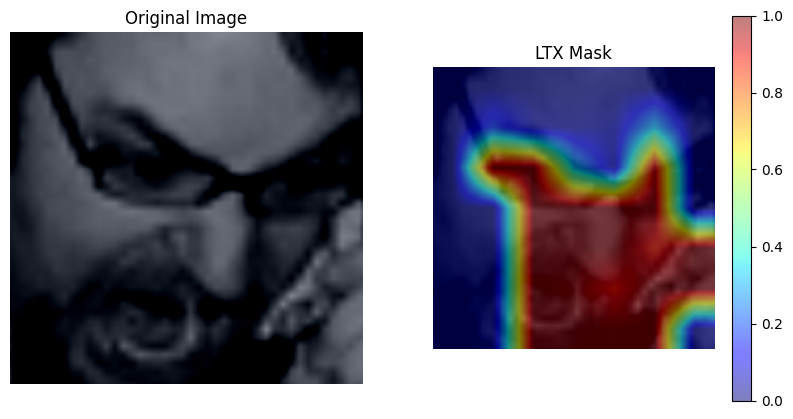

In [64]:
sample = next(iter(test_loader))
# num_images = len(sample[0])
num_images = 1
pre_trained_ltx = LTX.load_from_checkpoint(os.path.join(checkpoints_path, "best-checkpoint.ckpt"), explained_model=explained_model, explainer=explainer)

pre_trained_ltx = pre_trained_ltx.to(device)

# run ltx on the data point
trainer = Trainer(
    max_epochs=10,
    accelerator='gpu',
    enable_checkpointing=False,
    logger=False,
)

for i in tqdm(range(num_images)):
    image = sample[0][i]
    target = sample[1][i]
    data_point = SingleTensorData(image=image, target=target)
    data_loader = DataLoader(data_point, batch_size=1)

    # trainer.fit(
    #     model=pre_trained_ltx,
    #     train_dataloaders=data_loader,
    #     val_dataloaders=data_loader,
        
    # )



# plot the original image and the mask
with torch.no_grad():
    mask, token_mask = pre_trained_ltx(image.unsqueeze(0).to(device))

plot_mask = mask.reshape(img_size, img_size)
# normalize the mask to [0, 1] for visualization
t_min = plot_mask.min()
t_max = plot_mask.max()
plot_mask = (plot_mask - t_min) / (t_max - t_min)
# expand to 3 channels for visualization
# plot_mask = plot_mask.unsqueeze(-1).repeat(1, 1, 3)

# denormalize img
rgb_img = image + torch.tensor(processor.image_mean).view(3, 1, 1)
rgb_img = rgb_img * torch.tensor(processor.image_std).view(3, 1, 1)
rgb_img = rgb_img.clamp(0, 1).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(rgb_img)
plt.imshow(plot_mask.cpu().numpy(), cmap='jet', alpha=0.5)
plt.colorbar()  
plt.title("LTX Mask")
plt.axis('off')
plt.show()

In [61]:
rgb_img.shape

(224, 224, 3)

In [29]:
from matplotlib import cm
import numpy as np

C:\Users\ilanv\AppData\Local\Temp\ipykernel_13756\375012318.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap = cm.get_cmap("jet")(plot_mask.cpu().numpy())[:, :, :3]  # drop alpha channel
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.0648367].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

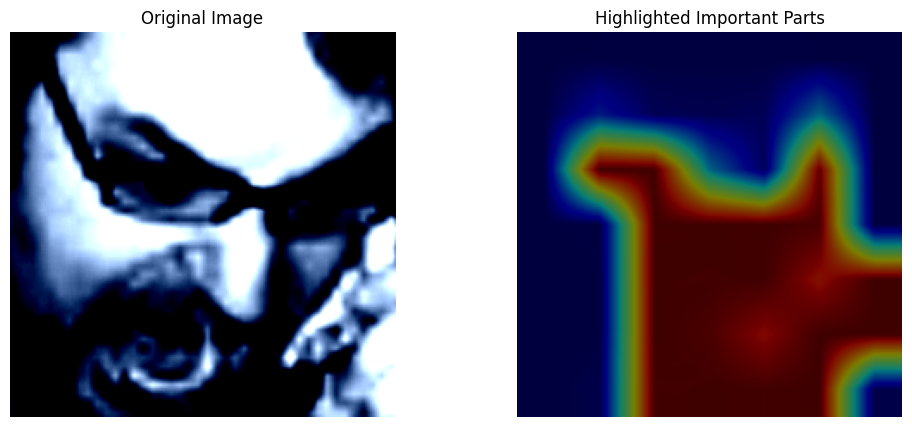

In [30]:
with torch.no_grad():
    mask, token_mask = pre_trained_ltx(image.unsqueeze(0).to(device))

plot_mask = mask.reshape(img_size, img_size)

# normalize mask to [0, 1]
t_min = plot_mask.min()
t_max = plot_mask.max()
plot_mask = (plot_mask - t_min) / (t_max - t_min)

# convert mask to heatmap (matplotlib colormap)
heatmap = cm.get_cmap("jet")(plot_mask.cpu().numpy())[:, :, :3]  # drop alpha channel
heatmap = (heatmap * 255).astype(np.uint8)

# original image to uint8
img_np = image.permute(1, 2, 0).cpu().numpy()
if img_np.max() <= 1.0:
    img_np = (img_np * 255).astype(np.uint8)

# blend heatmap and original image
alpha = 0.5  # overlay strength
overlay = (img_np.astype(np.float32) * (1 - alpha) + heatmap.astype(np.float32) * alpha).astype(np.uint8)

# plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Highlighted Important Parts")
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.0648367].


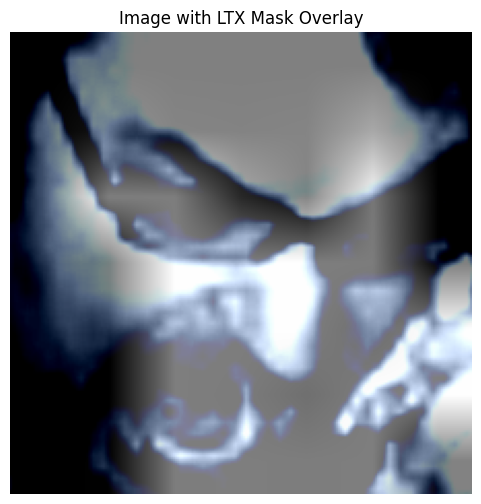

In [24]:
plt.figure(figsize=(6, 6))
img_np = image.permute(1, 2, 0).cpu().numpy()
mask_np = plot_mask.cpu().numpy()

plt.imshow(img_np)
plt.imshow(mask_np, alpha=0.5)  # alpha controls transparency
plt.title("Image with LTX Mask Overlay")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.0648367].


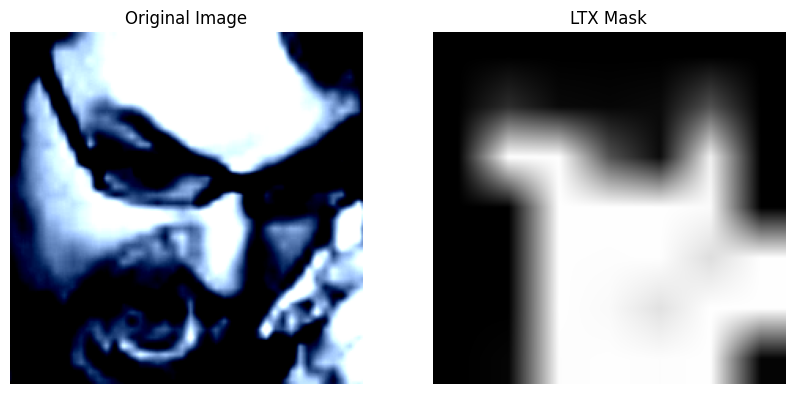

In [23]:
plot_mask = mask.reshape(img_size, img_size)
# normalize the mask to [0, 1] for visualization
t_min = plot_mask.min()
t_max = plot_mask.max()
plot_mask = (plot_mask - t_min) / (t_max - t_min)
# expand to 3 channels for visualization
plot_mask = plot_mask.unsqueeze(-1).repeat(1, 1, 3)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(plot_mask.cpu().numpy())
plt.title("LTX Mask")
plt.axis('off')
plt.show()